# Chemoinformatics using Python: Predict Solubility with ML and DL models

## Part II : Obtain all Molecular descriptors and Generate Fingerprints

##### This notebook was inspired by the Dr. Gashaw videos . Link to the youtube video: https://www.youtube.com/watch?v=9i9SY6Nd1Zw and https://www.youtube.com/watch?v=-oHqQBUyrQ0
##### and use the datasets as reported by Meng et al. doi: https://doi.org/10.1038/s41597-022-01154-3

### Import Packages

In [1]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Descriptors,rdMolDescriptors, Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.ML.Cluster import Butina

from mordred import Calculator, descriptors

import pandas as pd
import numpy as np
import random
import seaborn as sn

from tqdm import tqdm

import session_info
session_info.show()

### Exploratory analysis on the esol dataset
#### Import the database

In [2]:
path=r"C:\Users\sylv_\Documents\GitHub\SolCuration\clean\esol_stand.csv"
df= pd.read_csv(path)
df.head()

,smiles,logS,weight
0,BrC(Br)(Br)Br,-3.14,1.0
1,BrC(Br)Br,-1.91,1.0
2,BrCBr,-1.17,1.0
3,BrCCBr,-1.68,1.0
4,Brc1cc(Br)c(Br)cc1Br,-6.98,1.0


In [3]:
df.smiles[100]

'CC(=O)CCC1C(=O)N(c2ccccc2)N(c2ccccc2)C1=O'

#### Generate SMILES

In [4]:
def uniq_smiles (smiles):
    mols =[Chem.MolFromSmiles(smil) for smil in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

Uniq_Smiles = uniq_smiles(df.smiles)
len(Uniq_Smiles)

1116

#### Replace SMILES and looks for duplicates

In [5]:
df['smiles'] = Uniq_Smiles
duplicate_smile= df[df['smiles'].duplicated()]['smiles'].values
print(len(duplicate_smile))
df[df['smiles'].isin(duplicate_smile)].sort_values(by= ['smiles'])

6


,smiles,logS,weight
211,CC12CCC(CC1)C(C)(C)O2,-1.740,0.5
212,CC12CCC(CC1)C(C)(C)O2,-1.640,0.5
218,CC12CCC3C(CCC4CC(O)CCC43C)C1CCC2=O,-4.402,0.5
219,CC12CCC3C(CCC4CC(O)CCC43C)C1CCC2=O,-4.160,0.5
288,CCC1(C(C)C)C(=O)NC(=O)NC1=O,-2.210,0.5
289,CCC1(C(C)C)C(=O)NC(=O)NC1=O,-2.148,0.5
296,CCC1(CCC(C)C)C(=O)NC(=O)NC1=O,-2.658,0.5
297,CCC1(CCC(C)C)C(=O)NC(=O)NC1=O,-2.468,0.5
746,Cc1ncc([N+](=O)[O-])n1CCO,-1.260,0.5
747,Cc1ncc([N+](=O)[O-])n1CCO,-1.220,0.5


#### Drop duplicate to have a clean dataset

In [6]:
df_clean= df.drop_duplicates(subset=['smiles']).reset_index(drop= True)
len(df_clean)

1110

## Calculate molecular descriptor with RDKit

In [7]:
def RDkit_descrip(df):
    mol_list= [Chem.MolFromSmiles(element) for element in df.smiles]
    calc= MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names= calc.GetDescriptorNames()
    
    Mol_descriptors= [calc.CalcDescriptors(Chem.AddHs(mol))for mol in mol_list]
    return Mol_descriptors, desc_names

In [8]:
Mol_descriptors, desc_names= RDkit_descrip(df_clean)

In [9]:
df_200_descrip= pd.DataFrame(Mol_descriptors, columns=desc_names)
df_200_descrip.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,3.125000,-0.250000,3.125000,0.250000,0.598169,331.627,331.627,327.673348,32,0,...,0,0,0,0,0,0,0,0,0,0
1,6.687500,-0.812500,6.687500,0.812500,0.581278,252.731,251.723,249.762836,26,0,...,0,0,0,0,0,0,0,0,0,0
2,6.437500,-1.375000,6.437500,1.375000,0.490092,173.835,171.819,171.852324,20,0,...,0,0,0,0,0,0,0,0,0,0
3,6.744792,-2.000000,6.744792,2.000000,0.549640,187.862,183.830,185.867974,26,0,...,0,0,0,0,0,0,0,0,0,0
4,7.585324,0.323843,7.585324,0.323843,0.558724,393.698,391.682,389.688998,54,0,...,0,0,0,0,0,0,0,0,0,0


## Calculate Fingerprints with RDKit

In [10]:
def morgan_fpts(df):
    mol_list= [Chem.MolFromSmiles(element) for element in df.smiles]
    fpts=[AllChem.GetMorganFingerprintAsBitVect(mol,2,2048) for mol in mol_list]
    Morgan_fpts =[np.array(fpt) for fpt in fpts]
    return np.array(Morgan_fpts)

In [11]:
Morgan_fpts= morgan_fpts(df_clean)
Morgan_fpts.shape

(1110, 2048)

In [12]:
Data_Mor_fpts= pd.DataFrame(Morgan_fpts, columns= ['Col_{}'.format(i) for i in range (Morgan_fpts.shape[1])])
Data_Mor_fpts

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Calculate Descriptors with Mordred

In [13]:
def All_Mordred_descript(df):
    calc=Calculator(descriptors, ignore_3D= False)
    mol_list= [Chem.MolFromSmiles(element) for element in df.smiles]
    
    df_Mordred= calc.pandas(mol_list)
    return df_Mordred

In [14]:
mordred_desc= All_Mordred_descript(df_clean)
mordred_desc.shape

100%|██████████| 1110/1110 [00:24<00:00, 45.58it/s]


(1110, 1826)

In [15]:
mordred_desc

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,3.464102,3.464102,0,0,4.000000,2.000000,4.000000,4.000000,0.800000,2.444466,...,7.625107,29.418928,327.673348,65.534670,16,0,20.0,16.0,4.062500,1.000000
1,2.449490,2.449490,0,0,3.464102,1.732051,3.464102,3.464102,0.866025,2.178059,...,6.188264,24.179697,249.762836,49.952567,9,0,12.0,9.0,3.111111,1.000000
2,1.414214,1.414214,0,0,2.828427,1.414214,2.828427,2.828427,0.942809,1.849457,...,4.174387,17.310771,171.852324,34.370465,4,0,6.0,4.0,2.250000,1.000000
3,2.121320,2.340100,0,0,4.472136,1.618034,3.236068,4.472136,1.118034,2.155909,...,5.509388,22.328143,185.867974,23.233497,10,1,10.0,8.0,2.500000,1.250000
4,7.427747,7.165349,0,0,11.683239,2.302776,4.605551,11.683239,1.168324,3.206353,...,9.066585,39.732715,389.688998,32.474083,111,13,48.0,54.0,4.944444,2.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,3.535534,3.535534,0,0,6.472136,2.000000,3.618034,6.472136,1.294427,2.525424,...,7.147559,41.004802,68.026215,7.558468,15,0,20.0,20.0,1.250000,1.250000
1106,3.535534,3.535534,0,0,6.472136,2.000000,3.618034,6.472136,1.294427,2.525424,...,7.147559,41.004802,84.003371,9.333708,15,0,20.0,20.0,1.250000,1.250000
1107,11.192388,8.912312,0,0,19.448251,2.434764,4.869528,19.448251,1.389161,3.607247,...,9.705220,46.333857,180.068748,8.184943,271,22,76.0,91.0,2.944444,3.083333
1108,7.737734,6.634763,0,0,13.683239,2.302776,4.605551,13.683239,1.368324,3.249407,...,9.066816,39.856521,132.043596,9.431685,109,12,50.0,57.0,2.222222,2.277778


### Import another Dataset (ochem_stand.csv) and remove duplicates

In [16]:
path=r"C:\Users\sylv_\Documents\GitHub\SolCuration\clean\ochem_stand.csv"
df_2= pd.read_csv(path)
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4218 entries, 0 to 4217
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   smiles  4218 non-null   object 
 1   logS    4218 non-null   float64
 2   weight  4218 non-null   float64
dtypes: float64(2), object(1)
memory usage: 99.0+ KB


In [17]:
Uniq_Smiles = uniq_smiles(df_2.smiles)
print(len(Uniq_Smiles))
df_2['smiles'] = Uniq_Smiles
duplicate_smile= df_2[df_2['smiles'].duplicated()]['smiles'].values
print(len(duplicate_smile))
#list of duplicate
df_2[df_2['smiles'].isin(duplicate_smile)].sort_values(by= ['smiles'])
df_2_clean= df_2.drop_duplicates(subset=['smiles']).reset_index(drop= True)
print(len(df_2_clean))
df_2_clean

4218
553
3665


,smiles,logS,weight
0,Br/C=C/Br,-1.320,1.00
1,Br/C=C\Br,-1.460,0.50
2,BrC(Br)(Br)Br,-3.140,1.00
3,BrC(Br)Br,-1.910,0.75
4,BrC(Br)C(Br)Br,-2.720,1.00
...,...,...,...
3660,c1cncc(C2CCCCN2)c1,0.790,1.00
3661,c1cncnc1,1.100,1.00
3662,c1cnoc1,0.383,1.00
3663,c1ncc2[nH]cnc2n1,0.619,1.00


### Visualize Molecules in the dataframe

In [18]:
PandasTools.AddMoleculeColumnToFrame(df_2_clean, 'smiles', 'Structure')

,smiles,logS,weight,Structure
559,CC(C)OC(=O)C1(S(=O)(=O)c2ccc([N+](=O)[O-])cc2)...,-3.76,1.000000,
159,C=C/C=C/CC1=C(C)C(OC(=O)C2C(/C=C(/C)C(=O)OC)C2...,-4.62,1.000000,
3098,O=C(OCCO)c1ccccc1O,-1.16,1.000000,
895,CCC(N)Cc1c[nH]c2ccccc12,-2.60,0.333333,
1354,CCN(CCCl)CCCl,-3.03,1.000000,

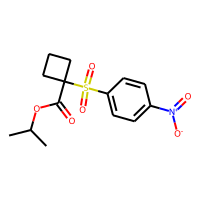
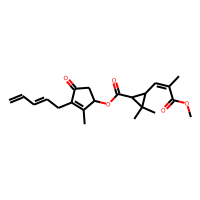
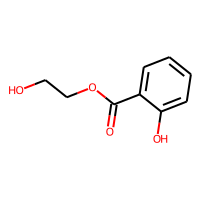
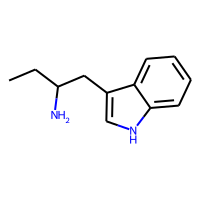
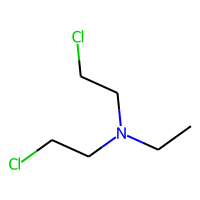

In [19]:
df_2_clean.sample(5)

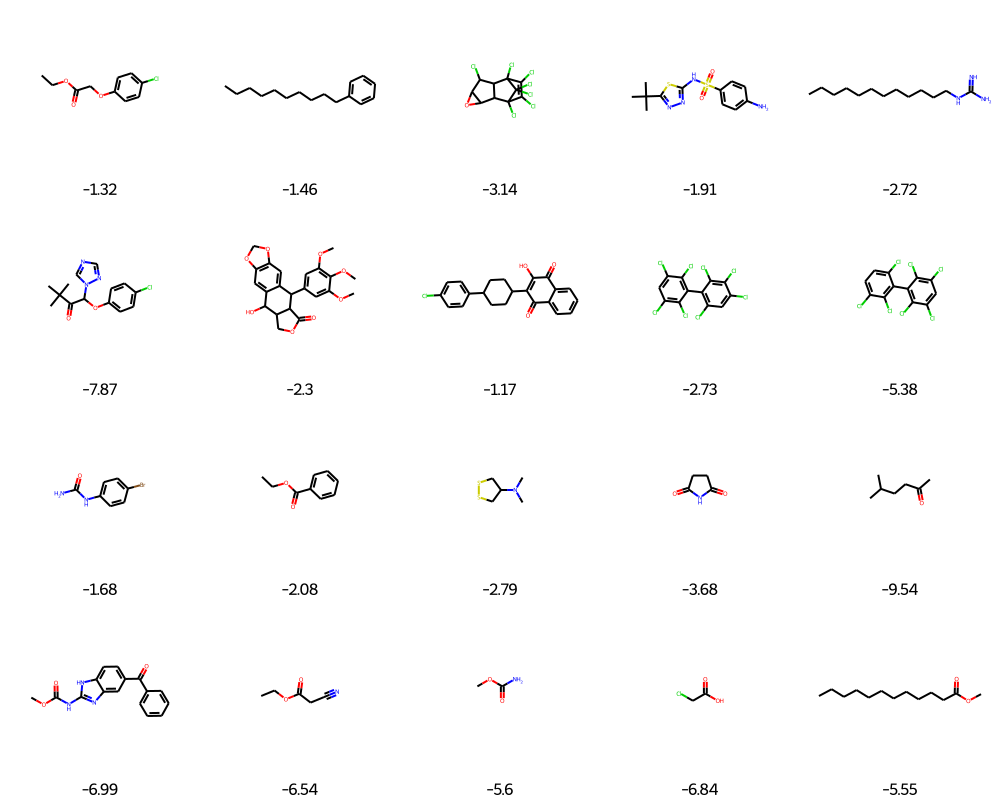

In [20]:
Draw.MolsToGridImage(random.sample([x for x in df_2_clean['Structure']],20),
                     maxMols=100, legends= [str(x) for x in df_2_clean.logS], subImgSize=(200,200), molsPerRow=5)

## Fingerprint
### For 1 molecule 

#### MACCS-key Fingerprint

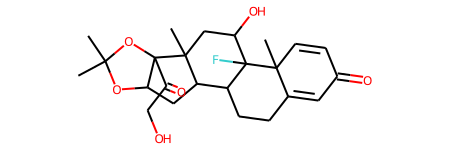

In [21]:
df_2_clean.Structure[694]

In [22]:
from rdkit.Chem import MACCSkeys
Mkeys=MACCSkeys.GenMACCSKeys(df_2_clean.Structure[694])

print (np.array(Mkeys))
print (np.array(Mkeys).shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0
 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 1 1 1
 0 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 0]
(167,)


##### obtain the ON bits

In [23]:
print ("Index:", tuple(Mkeys.GetOnBits()))
print ("Number:", Mkeys.GetNumOnBits())

Index: (26, 42, 50, 57, 66, 72, 74, 76, 82, 83, 87, 89, 91, 96, 99, 101, 104, 105, 107, 108, 109, 112, 115, 116, 118, 120, 123, 127, 128, 129, 131, 132, 134, 136, 137, 139, 140, 141, 143, 145, 146, 147, 149, 150, 152, 153, 154, 155, 157, 159, 160, 163, 164, 165)
Number: 54


#### Avalon Fingerprint

In [24]:
from rdkit.Avalon import pyAvalonTools
Av= pyAvalonTools.GetAvalonFP(df_2_clean.Structure[694], nBits= 512)
print (np.array(Av))

[1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 0
 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0
 1 1 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 1 1
 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1
 1 0 1 0 0 1 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0
 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0
 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1
 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 1 0
 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0
 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1
 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 1 0
 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1
 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0
 0 0 1 1 1 1 1 1 1 1 0 0 

In [25]:
print ("Index:", tuple(Av.GetOnBits()))
print ("Number:", Av.GetNumOnBits())

Index: (0, 2, 3, 4, 5, 7, 9, 10, 11, 13, 15, 17, 18, 21, 22, 23, 26, 29, 30, 31, 33, 34, 37, 38, 39, 41, 42, 44, 45, 47, 48, 49, 51, 52, 53, 58, 59, 67, 69, 70, 72, 74, 75, 77, 80, 81, 84, 85, 86, 91, 92, 93, 94, 99, 101, 102, 104, 105, 109, 110, 111, 112, 114, 115, 116, 117, 119, 120, 121, 124, 125, 126, 128, 129, 131, 132, 133, 134, 135, 137, 141, 142, 143, 145, 146, 147, 148, 150, 153, 154, 155, 157, 158, 159, 162, 164, 172, 176, 177, 178, 179, 180, 181, 182, 185, 186, 188, 189, 193, 195, 197, 198, 199, 201, 202, 206, 207, 208, 209, 212, 214, 219, 220, 222, 223, 224, 225, 226, 227, 229, 231, 233, 234, 238, 241, 244, 245, 246, 249, 250, 251, 252, 254, 256, 257, 258, 259, 260, 261, 264, 265, 266, 268, 270, 274, 275, 277, 278, 280, 281, 282, 285, 286, 288, 289, 290, 291, 294, 300, 304, 305, 306, 307, 308, 314, 315, 316, 318, 319, 321, 323, 324, 325, 327, 328, 331, 333, 334, 337, 338, 339, 340, 341, 342, 343, 345, 349, 350, 352, 353, 354, 355, 356, 357, 359, 360, 361, 362, 365, 366, 368

#### Atom-Pairs Fingerprint

In [26]:
AP= rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(df_2_clean.Structure[694], nBits= 512)
print (np.array(AP))
print ("Index:", tuple(AP.GetOnBits()))
print ("Number:", AP.GetNumOnBits())                           

[1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1
 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 0
 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1
 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0
 1 1 0 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1
 1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1
 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1
 0 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0
 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1
 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1
 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0
 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0
 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1
 1 0 0 1 1 1 1 1 0 0 0 1 

#### Topological-Torsions Fingerprint

In [27]:
TT= rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(df_2_clean.Structure[694], nBits= 512)
print (np.array(TT))
print ("Index:", tuple(TT.GetOnBits()))
print ("Number:", TT.GetNumOnBits())    

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1
 0 0 0 0 0 0 0 1 1 0 0 1 

#### Morgan-Circular Fingerprint

In [28]:
onbits={}
MF= AllChem.GetMorganFingerprintAsBitVect(df_2_clean.Structure[694],2, nBits= 512, bitInfo= onbits)
print (np.array(MF))
print ("Index:", tuple(MF.GetOnBits()))
print ("Number:", MF.GetNumOnBits())  

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 

##### Visualize the fragment that turn a bit ON

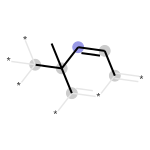

In [29]:
Draw.DrawMorganBit(df_2_clean.Structure[694],170,onbits)

###### Visualize all fragments that turn a bit ON

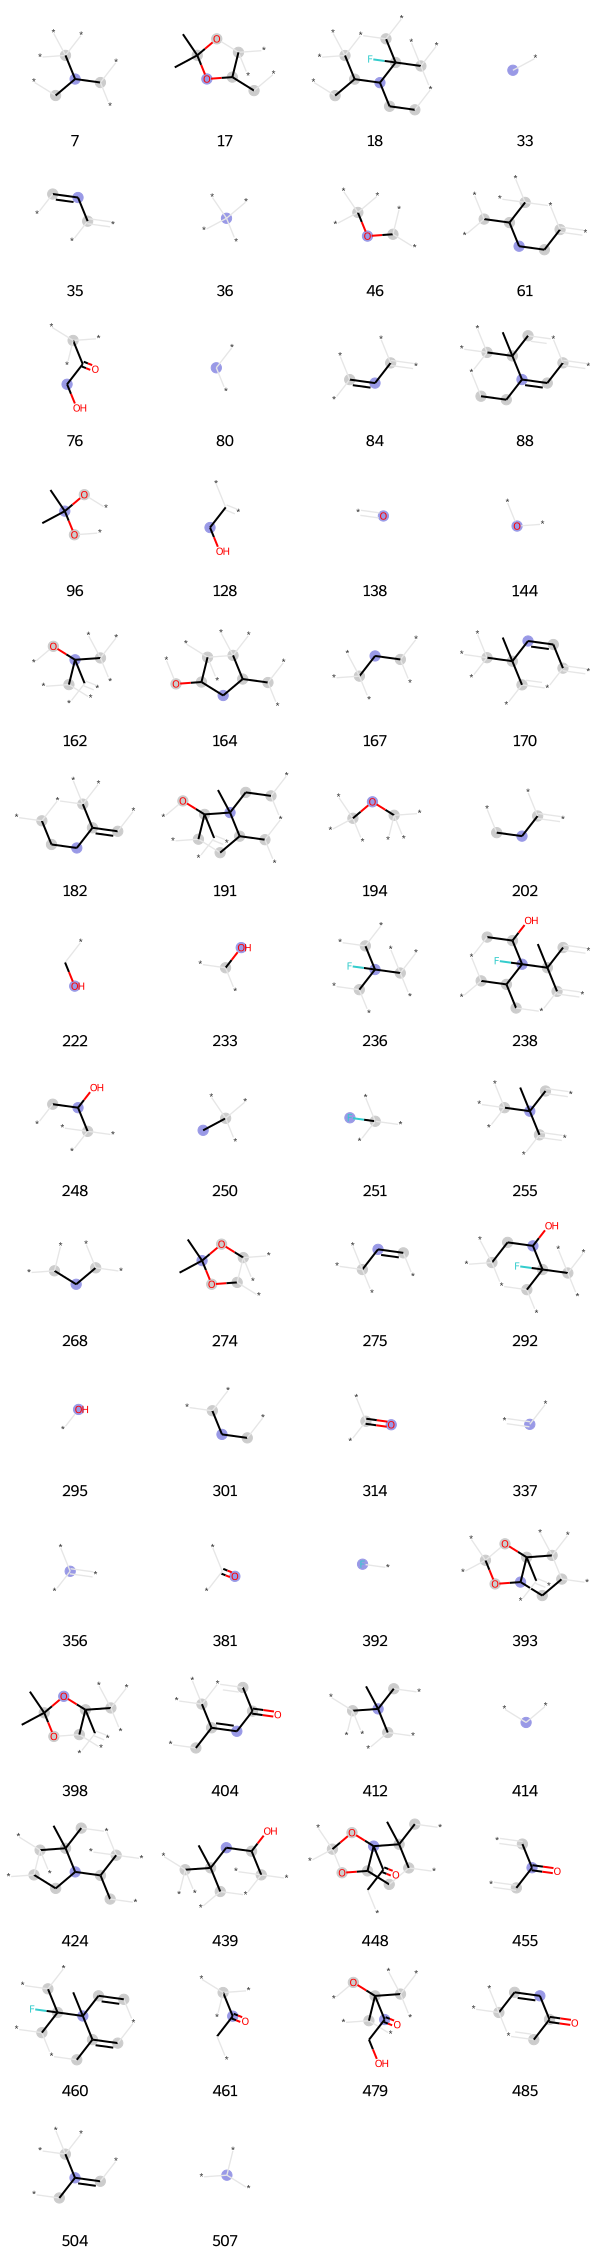

In [30]:
all_frag= [(df_2_clean.Structure[694],x,onbits) for x in MF.GetOnBits()]
Draw.DrawMorganBits(all_frag[:], molsPerRow = 4, legends= [str(x) for x in MF.GetOnBits()][:])

#### RDkit Fingerprint

In [31]:
RDonbits={}
RDk= AllChem.RDKFingerprint(df_2_clean.Structure[694],maxPath=5, fpSize= 512, bitInfo= RDonbits)
print (np.array(RDk))
print ("Index:", tuple(RDk.GetOnBits()))
print ("Number:", RDk.GetNumOnBits())

[0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0
 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0
 1 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 0 1 1
 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 0
 1 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 1 0 0 1 1 1
 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0
 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1
 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 0
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0
 1 1 0 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 0
 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 0
 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 0
 1 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0
 1 1 0 0 0 0 1 0 0 0 1 0 

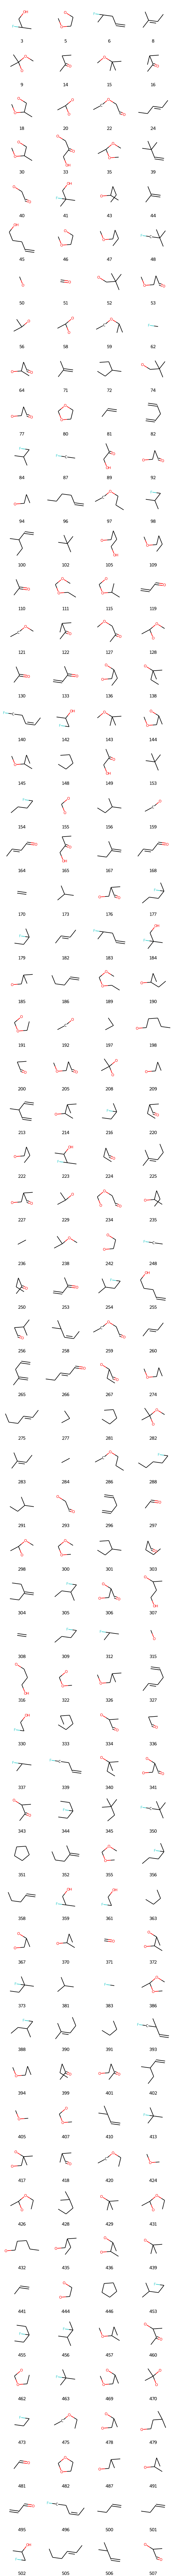

In [32]:
all_frag_rdk= [(df_2_clean.Structure[694],x,RDonbits) for x in RDk.GetOnBits()]
Draw.DrawRDKitBits(all_frag_rdk[:], molsPerRow = 4, legends= [str(x) for x in RDk.GetOnBits()][:])

### For multiple molecules

In [33]:
def generate_fpts(df):
    Morgan_fpts= [AllChem.GetMorganFingerprintAsBitVect(struct, 2, nBits = 2048) for struct in tqdm (df.Structure[:200])]
    Av_fpts = [pyAvalonTools.GetAvalonFP(struct, nBits = 2048) for struct in tqdm (df.Structure[:200])]
    TT_fpts= [rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(struct, nBits = 2048) for struct in tqdm (df.Structure[:200])]

    return np.array(Morgan_fpts),np.array(Av_fpts),np.array(TT_fpts)

In [34]:
Morg_fpts, Avfpts, TTfpts = generate_fpts(df_2_clean)

100%|██████████| 200/200 [00:00<00:00, 30738.76it/s]


In [35]:
Morg_fpts.shape

(200, 2048)

In [36]:
Avfpts.shape

(200, 2048)

In [37]:
TTfpts.shape

(200, 2048)

### For the whole dataset

In [38]:
def gen_avfpts(df):
    Av_fpts = [pyAvalonTools.GetAvalonFP(struct, nBits = 1024) for struct in tqdm (df.Structure)]
    return np.array(Av_fpts)

In [39]:
av_finger=gen_avfpts(df_2_clean)

100%|██████████| 3665/3665 [00:01<00:00, 3525.82it/s]


In [40]:
av_finger.shape

(3665, 1024)

### Exemple of similarity using fingerprints with a dataset on sedative (from Pubchem) 

#### Import the dataset

In [41]:
path=r"C:\Users\sylv_\Desktop\sedative.csv"
df_barb = pd.read_csv(path, sep=';')
df_barb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ChEMBL ID                        124 non-null    object 
 1   Name                             124 non-null    object 
 2   Synonyms                         124 non-null    object 
 3   Type                             124 non-null    object 
 4   Max Phase                        124 non-null    float64
 5   Molecular Weight                 123 non-null    float64
 6   Targets                          99 non-null     float64
 7   Bioactivities                    99 non-null     float64
 8   AlogP                            123 non-null    object 
 9   Polar Surface Area               123 non-null    object 
 10  HBA                              123 non-null    object 
 11  HBD                              123 non-null    object 
 12  #RO5 Violations       

In [42]:
df_barb.head()

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,Polar Surface Area,...,Heavy Atoms,HBA (Lipinski),HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Np Likeness Score,Molecular Species,Molecular Formula,Smiles,Inchi Key
0,CHEMBL655,MIDAZOLAM,MIDAZOLAM|MIDAZOLAM CIV|MIDAZOLAM IN 0.8% SODI...,Small molecule,4.0,325.77,54.0,353.0,4.32,30.18,...,23,3,0,0,325.0782,-0.60,NEUTRAL,C18H13ClFN3,Cc1ncc2n1-c1ccc(Cl)cc1C(c1ccccc1F)=NC2,DDLIGBOFAVUZHB-UHFFFAOYSA-N
1,CHEMBL1521495,BENTAZEPAM,BENTAZEPAM|CI-718,Small molecule,-1.0,296.39,12.0,36.0,3.42,41.46,...,21,3,1,0,296.0983,-0.84,NEUTRAL,C17H16N2OS,O=C1CN=C(c2ccccc2)c2c(sc3c2CCCC3)N1,AIZFEOPQVZBNGH-UHFFFAOYSA-N
2,CHEMBL2111144,ZOLAZEPAM,ZOLAZEPAM,Small molecule,-1.0,286.31,1.0,3.0,1.68,50.49,...,21,5,0,0,286.1230,-0.94,NEUTRAL,C15H15FN4O,Cc1nn(C)c2c1C(c1ccccc1F)=NCC(=O)N2C,GDSCFOSHSOWNDL-UHFFFAOYSA-N
3,CHEMBL591,ETHCHLORVYNOL,ALVINOL|ARVYNOL|ETHCHLORVYNOL|ETHCHLORVYNOL CI...,Small molecule,4.0,144.60,4.0,32.0,1.51,20.23,...,9,1,1,0,144.0342,0.63,NEUTRAL,C7H9ClO,C#CC(O)(/C=C/Cl)CC,ZEHYJZXQEQOSON-AATRIKPKSA-N
4,CHEMBL503565,VINBARBITAL,BUTENEMAL|NSC-117442|VINBARBITAL|VINBARBITAL S...,Small molecule,-1.0,224.26,1.0,1.0,1.11,75.27,...,16,5,2,0,224.1161,0.44,NEUTRAL,C11H16N2O3,CC/C=C(\C)C1(CC)C(=O)NC(=O)NC1=O,RAFOHKSPUDGZPR-VOTSOKGWSA-N


### Columns selection and Duplicate removal

#### Remove the NaN and rename the columns selected

In [43]:
df_sedative = df_barb.loc[:, ['Name', 'Smiles', 'Molecular Weight']].rename(columns={'Smiles': 'smiles',
                                                                                    'Molecular Weight' : 'Mw'})
df_sedative.info()
df_sedative= df_sedative.dropna()
df_sedative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    124 non-null    object 
 1   smiles  123 non-null    object 
 2   Mw      123 non-null    float64
dtypes: float64(1), object(2)
memory usage: 3.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 123 entries, 0 to 123
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    123 non-null    object 
 1   smiles  123 non-null    object 
 2   Mw      123 non-null    float64
dtypes: float64(1), object(2)
memory usage: 3.8+ KB


#### Draw the structure and incorporation in the dataframe

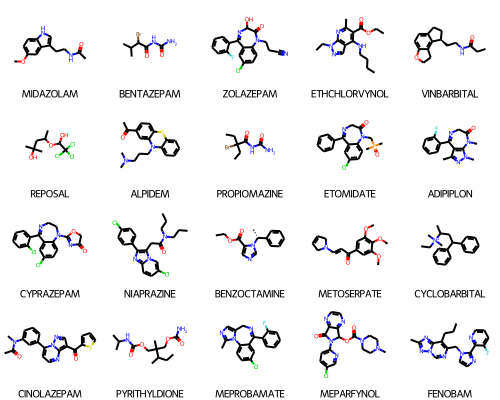

In [44]:
PandasTools.AddMoleculeColumnToFrame(df_sedative, 'smiles', 'Structure')
Draw.MolsToGridImage(random.sample([x for x in df_sedative['Structure']],20),
                     maxMols=100, legends= [str(x) for x in df_sedative.Name], subImgSize=(100,100), molsPerRow=5)

#### Removing the salt and dimer

In [45]:
def clean_salt_and_dimer(df):
    #remove the salt from structure and adapt the smiles
    PandasTools.RemoveSaltsFromFrame(df, molCol='Structure')
    df['smiles'] = [Chem.MolToSmiles(struct) for struct in df['Structure']]
    # use the smiles to determine repetition in the structure and keep one then adapt the structure
    corrected =[]
    for smiles in df['smiles']:
        substrings= smiles.split('.')
        substrings
        unique_substrings = []
        for substring in substrings:
            if substring not in unique_substrings:
                unique_substrings.append(substring)
        corrected.append('.'.join(unique_substrings))
    df['smiles'] =corrected
    PandasTools.AddMoleculeColumnToFrame(df, 'smiles', 'Structure')
    # eliminate duplicates
    Uniq_Smiles = uniq_smiles(df.smiles)
    print(len(Uniq_Smiles))
    df['smiles'] = Uniq_Smiles
    duplicate_smile= df[df['smiles'].duplicated()]['smiles'].values
    #list of duplicate
    df[df['smiles'].isin(duplicate_smile)].sort_values(by= ['smiles'])
    df_clean= df.drop_duplicates(subset=['smiles']).reset_index(drop= True)
    print(len(df_clean))
    return df_clean

In [46]:
df_sedative_clean=clean_salt_and_dimer(df_sedative)
df_sedative_clean.info()

123
121
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       121 non-null    object 
 1   smiles     121 non-null    object 
 2   Mw         121 non-null    float64
 3   Structure  121 non-null    object 
dtypes: float64(1), object(3)
memory usage: 3.9+ KB


##### Verify for salt and dimer

,Name,smiles,Mw,Structure
0,ACETYLGLYCINAMIDE CHLORAL HYDRATE,CC(=O)NCC(N)=O.OC(O)C(Cl)(Cl)Cl,281.52,
1,DICHLORALPHENAZONE,Cc1cc(=O)n(-c2ccccc2)n1C.OC(O)C(Cl)(Cl)Cl,519.04,

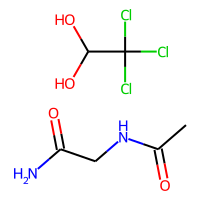
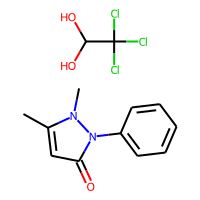

In [47]:
df_sedative_salt = df_sedative[df_sedative['smiles'].str.contains('\.')].reset_index(drop= True)
df_sedative_salt

In [48]:
### Ok because there no more dimer and the part of these salt are active compound(no Cl or Na for exemple)

## Calcul Molecular similarity and clustering for the sedative dataset

### Calcul of fingerprint for the whole dataset

In [49]:
def gen_morgfpts(df):
    morgfpts = [AllChem.GetMorganFingerprintAsBitVect(struct, 7, nBits = 512) for struct in tqdm(df.Structure)]
    return morgfpts

In [50]:
sedative_morgfpts= gen_morgfpts(df_sedative)

100%|██████████| 123/123 [00:00<00:00, 12932.08it/s]


In [51]:
len(sedative_morgfpts)

123

,Name,smiles,Mw,Structure,morg_fpts
0,MIDAZOLAM,Cc1ncc2n1-c1ccc(Cl)cc1C(c1ccccc1F)=NC2,325.77,,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,BENTAZEPAM,O=C1CN=C(c2ccccc2)c2c(sc3c2CCCC3)N1,296.39,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
2,ZOLAZEPAM,Cc1nn(C)c2c1C(c1ccccc1F)=NCC(=O)N2C,286.31,,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,ETHCHLORVYNOL,C#CC(O)(/C=C/Cl)CC,144.60,,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,VINBARBITAL,CC/C=C(\C)C1(CC)C(=O)NC(=O)NC1=O,224.26,,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
119,BROMISOVALUM,CC(C)C(Br)C(=O)NC(N)=O,223.07,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
120,OCINAPLON,O=C(c1ccccn1)c1cnn2c(-c3ccncc3)ccnc12,301.31,,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
121,NECOPIDEM,CCc1ccc(-c2nc3ccc(C)cn3c2CN(C)C(=O)CC(C)C)cc1,363.51,,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
122,SUPROCLONE,CCC(=O)N1CCN(C(=O)OC2C3=C(SCCS3)C(=O)N2c2ccc3c...,520.04,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."

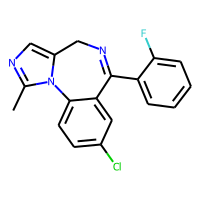
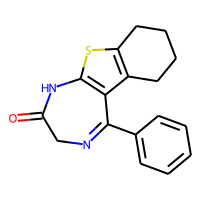
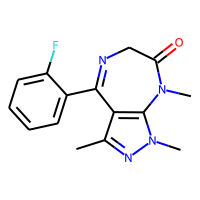
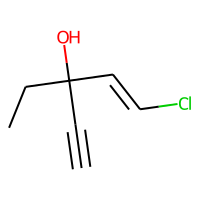
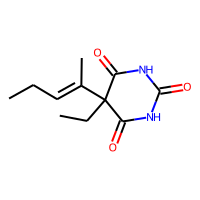
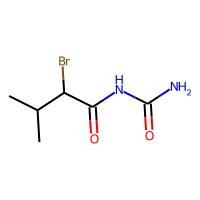
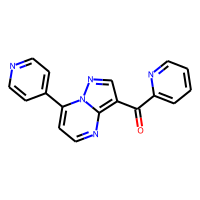
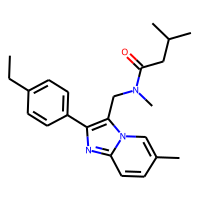
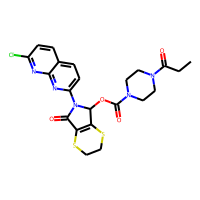
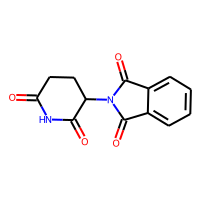

In [52]:
df_sedative['morg_fpts']= sedative_morgfpts
df_sedative

In [53]:
for index in tqdm(df_sedative.index):
    fp_ref= df_sedative.at[index,'morg_fpts']
    col_name = df_sedative.at[index,'Name']
    similarity_list = []
    
    for mol in df_sedative.Structure:
        fp= AllChem.GetMorganFingerprintAsBitVect(mol,2)
        sim= DataStructs.TanimotoSimilarity(fp_ref,fp)
        similarity_list.append(sim)
    df_sedative[col_name] = similarity_list

 67%|██████▋   | 82/123 [00:00<00:00, 199.88it/s]C:\Users\sylv_\AppData\Local\Temp\ipykernel_2184\2251510976.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sedative[col_name] = similarity_list
C:\Users\sylv_\AppData\Local\Temp\ipykernel_2184\2251510976.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sedative[col_name] = similarity_list
C:\Users\sylv_\AppData\Local\Temp\ipykernel_2184\2251510976.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

,Name,smiles,Mw,Structure,morg_fpts,MIDAZOLAM,BENTAZEPAM,ZOLAZEPAM,ETHCHLORVYNOL,VINBARBITAL,...,CHLORHEXADOL,CLORETHATE,MIDAFLUR,ROLETAMIDE,ESZOPICLONE,BROMISOVALUM,OCINAPLON,NECOPIDEM,SUPROCLONE,THALIDOMIDE
0,MIDAZOLAM,Cc1ncc2n1-c1ccc(Cl)cc1C(c1ccccc1F)=NC2,325.77,,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.558442,0.125000,0.277108,0.065574,0.025974,...,0.074627,0.016129,0.080645,0.085106,0.168142,0.047619,0.121495,0.127273,0.098592,0.113924
1,BENTAZEPAM,O=C1CN=C(c2ccccc2)c2c(sc3c2CCCC3)N1,296.39,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",0.126214,0.527027,0.186047,0.033898,0.071429,...,0.014925,0.017241,0.105263,0.076923,0.122807,0.033333,0.104762,0.132075,0.109489,0.183099
2,ZOLAZEPAM,Cc1nn(C)c2c1C(c1ccccc1F)=NCC(=O)N2C,286.31,,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.242105,0.150000,0.650794,0.032787,0.100000,...,0.076923,0.016667,0.065574,0.086957,0.130435,0.032258,0.123810,0.119266,0.100000,0.146667
3,ETHCHLORVYNOL,C#CC(O)(/C=C/Cl)CC,144.60,,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.065217,0.021505,0.024390,0.954545,0.117647,...,0.136364,0.108108,0.097561,0.052632,0.057692,0.073171,0.031579,0.073684,0.063492,0.031250
4,VINBARBITAL,CC/C=C(\C)C1(CC)C(=O)NC(=O)NC1=O,224.26,,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.030000,0.075269,0.085366,0.142857,0.722222,...,0.057692,0.069767,0.111111,0.062500,0.095238,0.065217,0.040404,0.091837,0.085938,0.075758

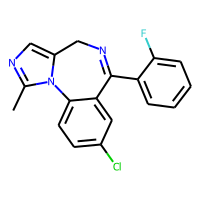
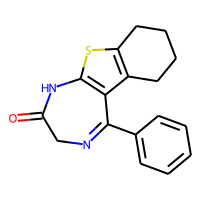
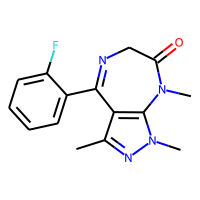
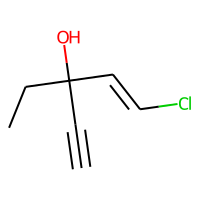
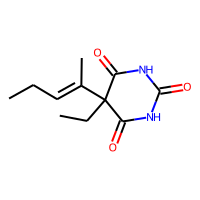

In [54]:
df_sedative.head()

In [55]:
df_sedative_visual= df_sedative.drop(['smiles', 'Mw','morg_fpts'], axis =1)
dataset_20= df_sedative_visual.iloc[22:42, 24:44]

color_map= sn.light_palette("blue", as_cmap= True)
gradient_color = dataset_20.style.background_gradient(cmap=color_map)
gradient_color

,FASIPLON,DEXTROMETHORPHAN,PROXIBARBAL,LOPRAZOLAM,CHLORAL HYDRATE,SARIPIDEM,VALNOCTAMIDE,CAPURIDE,DIAZEPAM,FLUNITRAZEPAM,DEXTROMETHORPHAN HYDROBROMIDE,DIVAPLON,ACETYLGLYCINAMIDE CHLORAL HYDRATE,DECLENPERONE,LORMETAZEPAM,RECLAZEPAM,PRAZEPAM,HALAZEPAM,TRICETAMIDE,MECLOQUALONE
22,0.640625,0.135417,0.068493,0.089655,0.000000,0.102804,0.070175,0.060606,0.085106,0.084906,0.135417,0.345238,0.031746,0.100775,0.060000,0.101852,0.095238,0.087379,0.112360,0.096386
23,0.115789,0.617647,0.082192,0.127660,0.020000,0.101852,0.068966,0.075758,0.157303,0.126214,0.617647,0.151515,0.047619,0.117188,0.175824,0.176471,0.148515,0.118812,0.149425,0.135802
24,0.068966,0.065934,0.783784,0.065693,0.085714,0.081633,0.139535,0.115385,0.058824,0.072917,0.065934,0.097826,0.127660,0.092437,0.093023,0.070000,0.072917,0.063830,0.115385,0.112676
25,0.079646,0.166667,0.079545,0.495726,0.030769,0.125000,0.054054,0.060976,0.279570,0.346939,0.166667,0.130435,0.064935,0.104167,0.294737,0.283019,0.245283,0.240385,0.094340,0.186813
26,0.000000,0.013158,0.069767,0.024390,1.000000,0.061728,0.115385,0.085714,0.029412,0.012195,0.013158,0.025316,0.375000,0.018519,0.057143,0.035714,0.024691,0.038961,0.015152,0.092593
27,0.125000,0.087379,0.094595,0.110345,0.060000,0.571429,0.163636,0.140625,0.179775,0.134615,0.087379,0.208333,0.133333,0.090226,0.159574,0.161905,0.180000,0.185567,0.200000,0.205128
28,0.092105,0.048193,0.120000,0.070866,0.120000,0.129412,0.950000,0.500000,0.038961,0.044944,0.048193,0.123457,0.228571,0.043478,0.090909,0.031915,0.056818,0.046512,0.115942,0.095238
29,0.100000,0.057471,0.109091,0.076336,0.100000,0.122222,0.571429,0.827586,0.049383,0.053763,0.057471,0.116279,0.230769,0.050420,0.098765,0.040816,0.065217,0.043956,0.123288,0.057143
30,0.062500,0.139785,0.071429,0.192308,0.044444,0.150000,0.054545,0.046875,0.622951,0.349398,0.139785,0.111111,0.087719,0.120968,0.320513,0.274725,0.417722,0.415584,0.116279,0.205479
31,0.058824,0.166667,0.080000,0.257812,0.019231,0.120370,0.066667,0.057971,0.400000,0.594595,0.166667,0.094340,0.079365,0.141732,0.267442,0.220000,0.296703,0.292135,0.085106,0.146341


## Taylor-Butina Clustering

In [56]:
def Taylor_Butina_cluster(fpts, distThresh = 0.82):
    #generate the distance matrix:
    dist_mat = []
    nfpts= len(fpts)
    
    for i in tqdm (range(1,nfpts)):
        # generate Tanimoto similarity
        Tanimoto_coeffs= DataStructs.BulkTanimotoSimilarity(fpts[i], fpts[:i])
        dist_mat.extend([1-j for j in Tanimoto_coeffs])
    
    #cluster the tanimoto score
    clusters =Butina.ClusterData(dist_mat, nfpts, distThresh, isDistData= True)
    cluster_id_list = [0] * nfpts
    for idx, cluster in enumerate(clusters,1):
        for member in cluster:
            cluster_id_list[member] = idx
    return cluster_id_list

In [57]:
#  we use the morgan fingerprints already calculated and stored in variable : sedative_morgfpts

In [58]:
cluster_id= Taylor_Butina_cluster(sedative_morgfpts)

100%|██████████| 122/122 [00:00<00:00, 122271.23it/s]


In [59]:
len(np.unique(cluster_id))

26

C:\Users\sylv_\AppData\Local\Temp\ipykernel_2184\274913010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sedative_cluster['Cluster'] = cluster_id


,Name,Structure,Cluster
0,MIDAZOLAM,,1
1,BENTAZEPAM,,1
2,ZOLAZEPAM,,1
3,ETHCHLORVYNOL,,22
4,VINBARBITAL,,2
5,REPOSAL,,2
6,ALPIDEM,,1
7,PROPIOMAZINE,,1
8,ETOMIDATE,,2
9,ADIPIPLON,,13

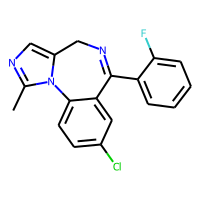
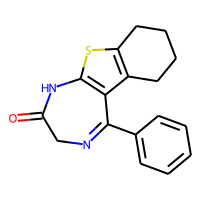
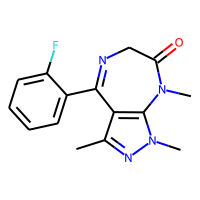
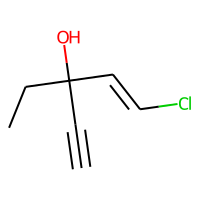
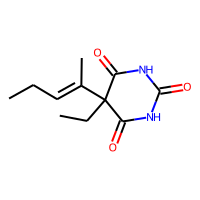
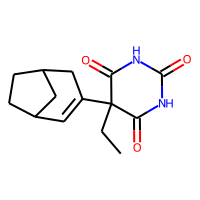
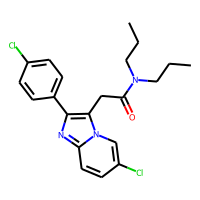
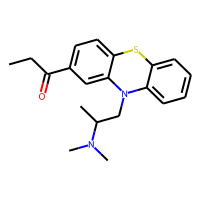
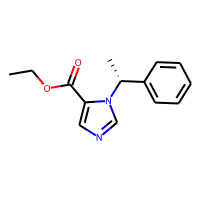
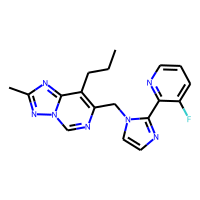

In [60]:
df_sedative_cluster= df_sedative[['Name', 'Structure']]
df_sedative_cluster['Cluster'] = cluster_id
df_sedative_cluster.head(10)

In [61]:
df_sedative_cluster.groupby('Cluster')['Structure'].count()

Cluster
1     32
2     24
3      2
4     12
5      7
6      9
7      7
8      2
9      1
10     3
11     2
12     1
13     2
14     2
15     3
16     1
17     1
18     3
19     1
20     1
21     1
22     2
23     1
24     1
25     1
26     1
Name: Structure, dtype: int64

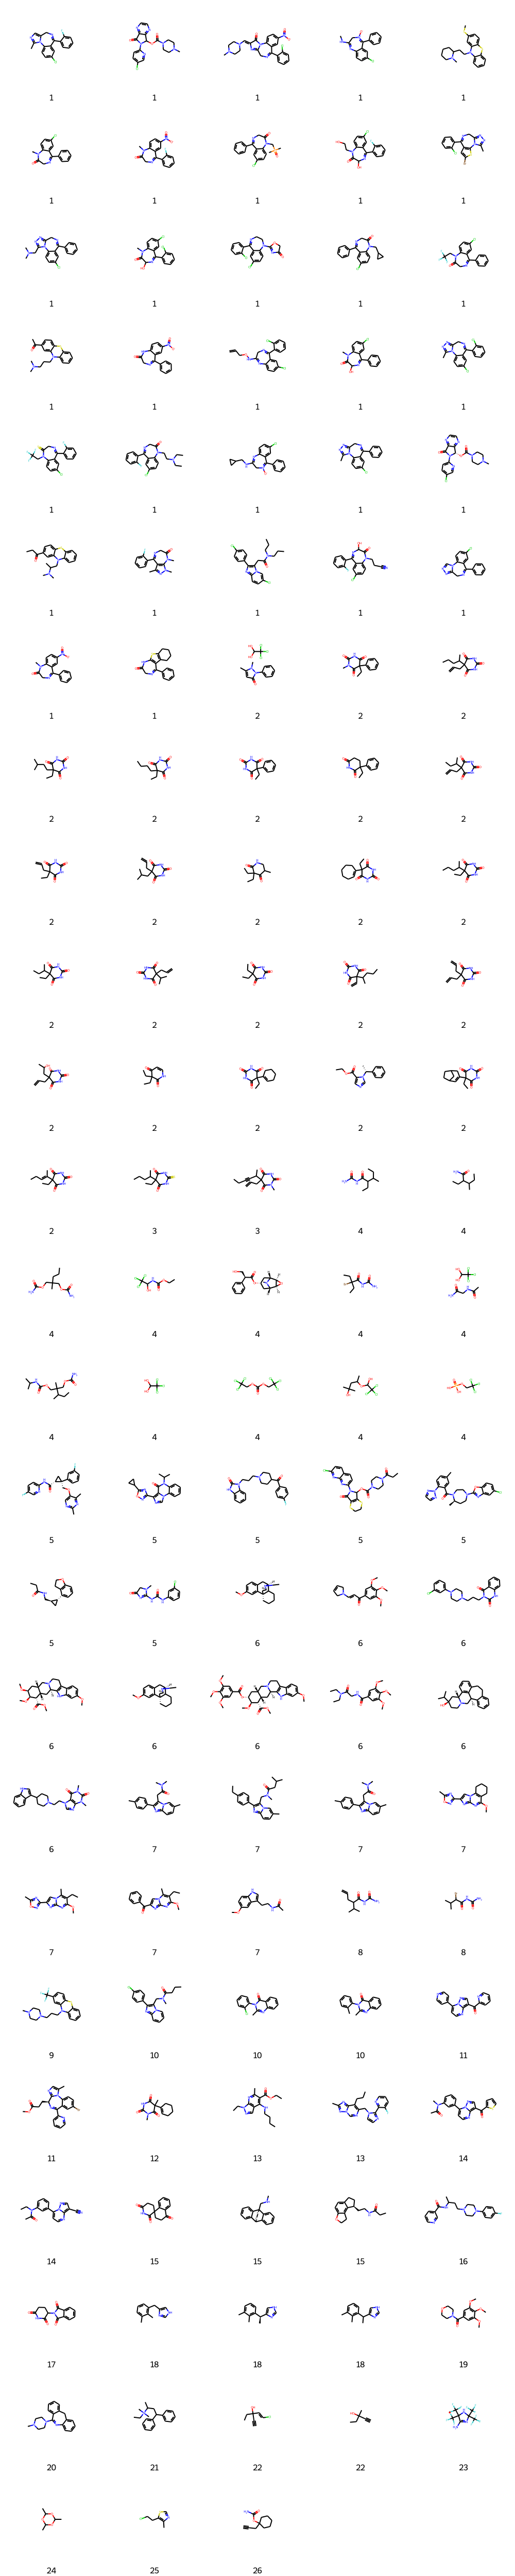

In [62]:
df_sedative_cluster_sorted= df_sedative_cluster.sort_values(['Cluster'])
Draw.MolsToGridImage ([mol for mol in df_sedative_cluster_sorted['Structure']], maxMols=200, legends=[str(x) for x in df_sedative_cluster_sorted.Cluster]
                      , subImgSize=(200,200), molsPerRow=5)

In [63]:
# Parameters that influence the clustering: the number and the distance that it is used to generated the fingerprints and the distance threshold during the clustering

### Filter molecule containing specific pattern in the dataset 

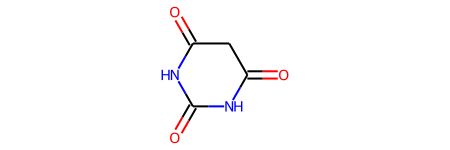

In [64]:
barbiturate = AllChem.MolFromSmiles("O=C1NC(=O)NC(=O)C1")
barbiturate                                   

,Name,smiles,Mw,Structure,morg_fpts,MIDAZOLAM,BENTAZEPAM,ZOLAZEPAM,ETHCHLORVYNOL,VINBARBITAL,...,CHLORHEXADOL,CLORETHATE,MIDAFLUR,ROLETAMIDE,ESZOPICLONE,BROMISOVALUM,OCINAPLON,NECOPIDEM,SUPROCLONE,THALIDOMIDE
4,VINBARBITAL,CC/C=C(\C)C1(CC)C(=O)NC(=O)NC1=O,224.26,,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.030000,0.075269,0.085366,0.142857,0.722222,...,0.057692,0.069767,0.111111,0.062500,0.095238,0.065217,0.040404,0.091837,0.085938,0.075758
5,REPOSAL,CCC1(C2=CC3CCC(C2)C3)C(=O)NC(=O)NC1=O,262.31,,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.046729,0.101010,0.113636,0.075472,0.245614,...,0.032258,0.057692,0.072727,0.068182,0.068966,0.035714,0.056604,0.115385,0.096296,0.142857
14,CYCLOBARBITAL,CCC1(C2=CCCCC2)C(=O)NC(=O)NC1=O,236.27,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.039216,0.144444,0.095238,0.085106,0.250000,...,0.035714,0.065217,0.081633,0.060241,0.072727,0.040000,0.049505,0.100000,0.092308,0.138462
21,ALLOBARBITAL,C=CCC1(CC=C)C(=O)NC(=O)NC1=O,208.22,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.054348,0.080460,0.050633,0.105263,0.244444,...,0.042553,0.052632,0.073171,0.053333,0.048077,0.023810,0.043011,0.041237,0.039062,0.101695
24,PROXIBARBAL,C=CCC1(CC(C)O)C(=O)NC(=O)NC1=O,226.23,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.060000,0.095745,0.057471,0.133333,0.250000,...,0.137255,0.065217,0.060000,0.073171,0.072727,0.106383,0.070707,0.078431,0.067669,0.088235
49,BUTABARBITAL,CCC(C)C1(CC)C(=O)NC(=O)NC1=O,212.25,,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.042105,0.090909,0.062500,0.100000,0.288889,...,0.133333,0.050000,0.095238,0.038462,0.047170,0.125000,0.020619,0.119565,0.062992,0.080645
54,SECOBARBITAL,C=CCC1(C(C)CCC)C(=O)NC(=O)NC1=O,238.29,,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...",0.060606,0.085106,0.058140,0.136364,0.254902,...,0.117647,0.043478,0.083333,0.074074,0.073394,0.085106,0.060606,0.101010,0.060150,0.089552
55,MEPHOBARBITAL,CCC1(c2ccccc2)C(=O)NC(=O)N(C)C1=O,246.27,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.080808,0.118280,0.162500,0.083333,0.200000,...,0.092593,0.041667,0.080000,0.098765,0.112150,0.039216,0.080808,0.110000,0.108527,0.153846
60,BUTETHAL,CCCCC1(CC)C(=O)NC(=O)NC1=O,212.25,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.020408,0.089888,0.048780,0.097561,0.282609,...,0.061224,0.048780,0.093023,0.078947,0.046729,0.069767,0.020408,0.083333,0.062500,0.079365
61,VINYLBITAL,C=CC1(C(C)CCC)C(=O)NC(=O)NC1=O,224.26,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0.039604,0.085106,0.045977,0.136364,0.280000,...,0.096154,0.043478,0.083333,0.060976,0.073394,0.085106,0.039604,0.101010,0.076336,0.089552

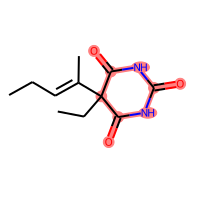
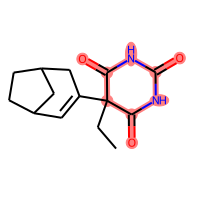
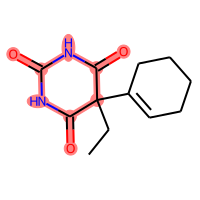
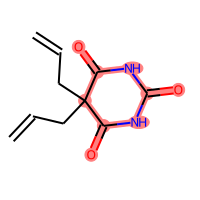
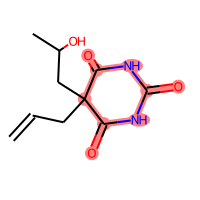
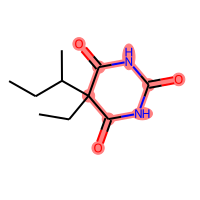
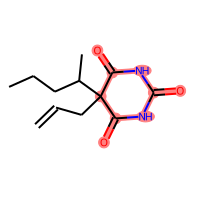
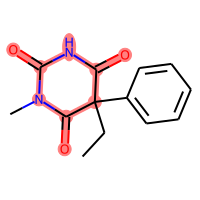
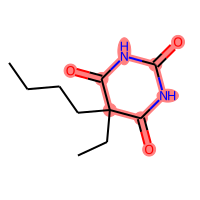
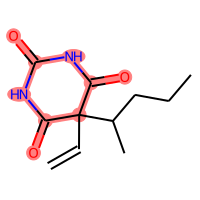
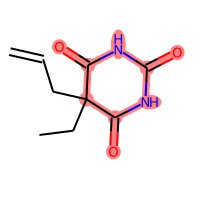
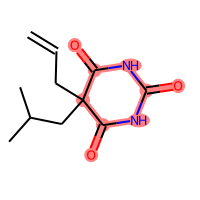
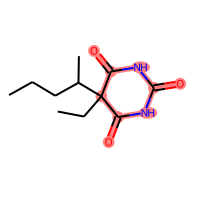
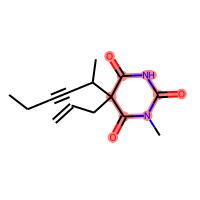
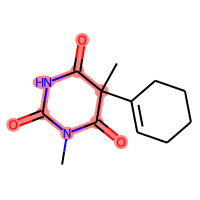
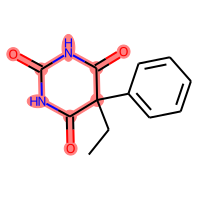
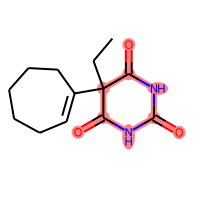
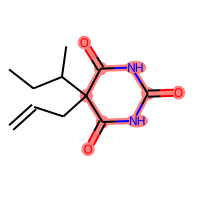
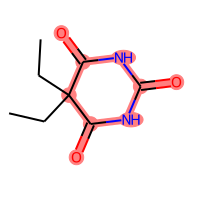
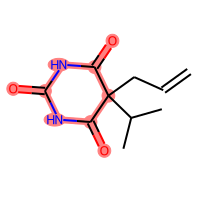
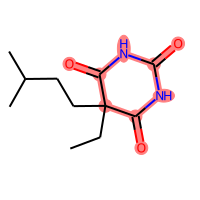

In [65]:
df_barbiturate= df_sedative[df_sedative["Structure"] >= barbiturate]
df_barbiturate